In [199]:
from functools import partial
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
import jax.random as jr
import jaxopt

# JAX Tutorial: From Zero to Newbie

This tutorial will guide you from zero JAX knowledge to a beginner level. It assumes only basic Python and some familiarity with NumPy and Matplotlib.

## The numpy API

In [200]:
# jax.numpy (jnp for friends) is the best entry point for new jax users.
# It is a lot like numpy.
a = jnp.ones((2))
b = jnp.array([1.0, 2.0])
a + b

Array([2., 3.], dtype=float32)

In [201]:
jnp.sin(a**2 + b**2) # really feels like numpy so far!

Array([ 0.9092974, -0.9589243], dtype=float32)

In [202]:
# The jax interface for random number is slighlt different from numpy for reasons that will be clear later on.
# let us stick with ordinary numpy (onp here) for now...
c = onp.random.randn((2))
# jax-numpy interoperability in action!
a + c

Array([ 0.6475965 , -0.08273995], dtype=float32)

In [203]:
c[1] = 0  # ok, this is numpy
# a[1] = 1 # throws an error!
# jax arrays are immutable, and in-place operations are not allowed!
a.at[1].set(0.0)

Array([1., 0.], dtype=float32)

## Automatic differentiation and optimization

In [204]:
# A jax model can be as simple as a plain python function:
def linear_model(params, x):
    y = x * params[0] + params[1]
    return y

In [205]:
params_true = jnp.array([1.0, 2.0]) # true, unknown value
params_init = onp.random.randn(2,) # initial guess (initialized with ordinary numpy)

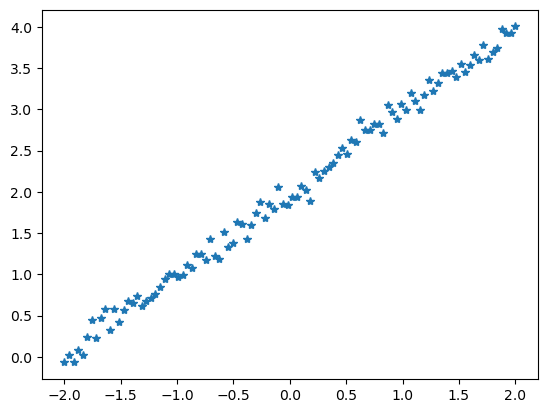

In [206]:
# Let us define some fake data
N = 100
x = onp.linspace(-2, 2, 100)
y = linear_model(params_true, x) + onp.random.randn(N) * 0.1
plt.plot(x, y, "*")

In [207]:
# Let us define the loss as a differentiable function
def loss_fn(p, y, x):
    y_hat = linear_model(p, x)
    loss = jnp.mean((y - y_hat) ** 2)
    return loss


loss_fn(params_init, y, x)

Array(11.531501, dtype=float32)

In [208]:
# This computes the gradient of the loss!
loss_grad_fn = jax.grad(loss_fn) # wrt first argument, p
loss_grad_fn(params_init, y, x)

Array([-2.8130994, -6.3459196], dtype=float32)

In [209]:
params_opt = params_init

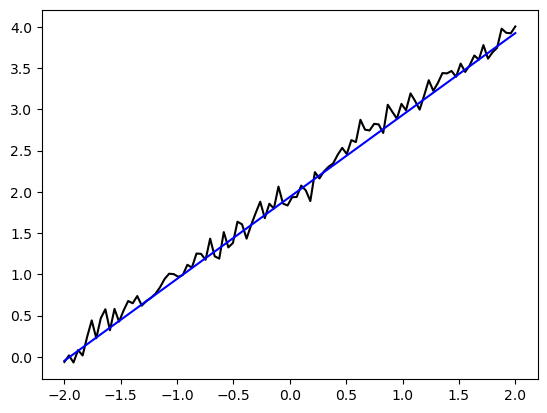

In [210]:
# We can wrap up a gradient-based optimization procedure!
# No bells & wistles!
lr = 1e-2
for _ in range(200):
    g = loss_grad_fn(params_opt, y, x)
    params_opt = params_opt - lr * g

plt.figure()
plt.plot(x, y, "k")
plt.plot(x, linear_model(params_opt, x), "b")

In [211]:
params_opt, params_true  # almost there...

(Array([0.9923637, 1.9378282], dtype=float32), Array([1., 2.], dtype=float32))

Traditional second-order solvers are also available in external libraries such as ``jaxopt``!

In [212]:
# BFGS
solver_bfgs = jaxopt.BFGS(fun=partial(loss_fn, y=y, x=x))
params_bfgs, state_bfgs = solver_bfgs.run(params_init)
params_bfgs

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 10.52042293548584 Stepsize:1.0  Decrease Error:2.855818510055542  Curvature Error:10.52042293548584 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.47206827998161316  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.7081024050712585  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 


Array([0.99652046, 1.9936339 ], dtype=float32)

In [213]:
# Levenberg-Marquardt
def resid_fn(p, y, x):
    y_hat = linear_model(p, x)
    resid = y - y_hat
    return resid


solver_lm = jaxopt.LevenbergMarquardt(lambda p: resid_fn(p, y, x), maxiter=100)
params_lm, state_lm = solver_lm.run(params_init)
params_lm

Array([0.9965193, 1.9936298], dtype=float32)

# Parallel execution with vmap

Jax provides a powerful ``vmap`` operator to *vectorize* function execution

In [237]:
# Let us build a model that acts on a single element.
def linear_model(weight, input):
    return weight @ input


in_feat = 3
out_feat = 10

W = onp.random.randn(out_feat, in_feat)  # 10 outputs, 3 inputs
x = onp.random.randn(in_feat)
y = linear_model(W, x)

# What if we have a vector of examples?
batch_size = 32
X = onp.random.randn(batch_size, in_feat)

# In pytorch, we would end up re-writing the linear layer in a less straightforward fashion:
Y = X @ W.T # :-(
Y.shape

# In jax, we would rather harness the power of vmap!
Y_vmap = jax.vmap(linear_model, in_axes=(None, 0))(W, X) # :-)
jnp.allclose(Y, Y_vmap, rtol=1e-4) # equivalent up to some numerical difference

Array(True, dtype=bool)

In [238]:
# Here (like above), we vectorize on the second argument only (the data!)
# This makes sense when we apply the same model to different data batches
batched_linear_model = jax.vmap(linear_model, in_axes=(None, 0))
Y_vmap = batched_linear_model(W, X)

In [240]:
# This is the converse: different models (an ensemble?) acting on the same data!
W_many = onp.random.randn(batch_size, out_feat, in_feat)
many_linear_models_same_data = jax.vmap(linear_model, in_axes=(0, None))
Y_many = many_linear_models_same_data(W_many, x)
Y_many.shape

(32, 10)

In [241]:
# By default, we vectorize on all arguments. We simulate several models over several datasets in parallel!
many_linear_models = jax.vmap(linear_model)
Y_many = many_linear_models(W_many, X)

# Jax data structure: PyTrees 

In Jax, function arguments can be (nested) collection objects generically referred to as pytrees this simplifies definition of structured models such as neural networks from scratch

Example: MLP with one hidden layer, parameters in a nested python dictionary

In [218]:
# Let us implement a MLP from scratch!
nn_sizes = [3, 16, 10]  # 3 inputs, 16 hidden layers, 10 outputs

params_nn = {
    "layer0": {
        "W": onp.random.randn(nn_sizes[1], nn_sizes[0]),
        "b": onp.random.randn(nn_sizes[1]),
    },
    "layer1": {
        "W": onp.random.randn(nn_sizes[2], nn_sizes[1]),
        "b": onp.random.randn(nn_sizes[2]),
    },
}

def nn_model(p, input):
    z = jax.nn.sigmoid(p["layer0"]["W"] @ input + p["layer0"]["b"])
    out = p["layer1"]["W"] @ z + p["layer1"]["b"]
    return out

In [219]:
x = onp.random.randn(
    nn_sizes[0],
)
y_nn = nn_model(params_nn, x)
y_nn.shape

(10,)

In [220]:
# batched execution of the MLP with vmap
X = onp.random.randn(batch_size, nn_sizes[0])
Y = jax.vmap(nn_model, in_axes=(None, 0))(params_nn, X)
Y.shape

(32, 10)

In [221]:
# batched loss computation
def loss_fn(p, input, target):
    predicted = jax.vmap(nn_model, in_axes=(None, 0))(p, input)
    error = target - predicted
    return jnp.mean(error**2)

Y_true = onp.random.randn(batch_size, nn_sizes[-1]) # some fake data
loss_fn(params_nn, X, Y_true)

Array(2.8984382, dtype=float32)

Jax has built-in tools for PyTree manipulation

In [222]:
params_sq = jax.tree.map(lambda x : x**2, params_nn) # all parameters squared (unary op)

In [223]:
params_sum = jax.tree.map(lambda x, y: x + y, params_nn, params_sq) # sum of two pytrees (binary op)

In [224]:
#params_flat, unflatten_pars = jax.flatten_util.ravel_pytree(params_nn) # flat vector, unflatten function

# Jax as a jit-compiled language

Jax functions can be jit-compiled for much faster execution. Common use case: compile gradient computations!

In [225]:
%%timeit -n 100
loss, grad = jax.value_and_grad(loss_fn)(params_nn, X, Y)

2.13 ms ± 88.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [226]:
grad_fn_jit = jax.jit(jax.value_and_grad(loss_fn))

In [227]:
%%timeit -n 1000
loss, grad = grad_fn_jit(params_nn, X, Y)

48.4 μs ± 9.12 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Random numbers in Jax

Native Jax random number generators always require a key to be passed explicitly

In [228]:
key = jr.key(1234)

In [229]:
jr.normal(key)

Array(-0.54019827, dtype=float32)

In [230]:
jr.normal(key, shape=(2,)) # same key=same result!

Array([ 0.43957582, -0.26563603], dtype=float32)

The Jax user is responsible of splitting the keys to generate different random numbers

In [231]:
key, subkey = jr.split(key, 2)
jr.normal(key, shape=(2,)), jr.normal(subkey, shape=(2,))

(Array([-1.2972969, -0.9846392], dtype=float32),
 Array([-1.7366334, -1.7102827], dtype=float32))

This is the price to pay for having a *pure function* interface!

In [232]:
# same arguments, different results. That's not a pure function.
onp.random.randn(2), onp.random.randn(2)

(array([-0.19275357,  0.86700287]), array([-0.11334645, -0.54615985]))

In [233]:
# same arguments, same results. This is a pure function!
jr.normal(key, shape=(2,)), jr.normal(key, shape=(2,))

(Array([-1.2972969, -0.9846392], dtype=float32),
 Array([-1.2972969, -0.9846392], dtype=float32))

# Higher-level interfaces: flax.linen

flax.linen offers a thin neural nerwork interface for jax

In [234]:
from flax import linen as nn

In [235]:
in_size = 10
out_size = 5
hidden = 16

class MLP(nn.Module):
    hidden: int
    out_size: int

    def setup(self):
        self.lin1 = nn.Dense(self.hidden)
        self.lin2 = nn.Dense(self.out_size)

    def __call__(self, input):
        x = nn.relu(self.lin1(input))
        x = self.lin2(x)
        return x

enc = MLP(hidden=hidden, out_size=out_size)
key, subkey = jr.split(key, 2)

# params are not part of the module!
params = enc.init(subkey, jnp.ones((in_size)))
params

{'params': {'lin1': {'kernel': Array([[ 0.34915778,  0.09149738,  0.08031028, -0.1144528 ,  0.317296  ,
            0.6505861 , -0.26838434,  0.16204348, -0.20969899, -0.18522389,
           -0.06305052, -0.07610493,  0.01470689, -0.19302115, -0.06943785,
           -0.15517578],
          [ 0.2830291 , -0.09197768, -0.32951352,  0.4423861 ,  0.12644179,
            0.05594965,  0.36738932, -0.3758351 , -0.03918812, -0.1170873 ,
           -0.55121595,  0.01673536, -0.11866205, -0.03521184,  0.02144702,
           -0.18217386],
          [ 0.36236632,  0.01984214, -0.3064592 , -0.05859586,  0.112603  ,
           -0.33131287,  0.13602741, -0.45689803, -0.43613708, -0.13689123,
           -0.3734352 , -0.0782427 , -0.12966101, -0.14389671,  0.16927539,
           -0.08479758],
          [ 0.3925566 ,  0.45545122,  0.05914405, -0.39626774,  0.5778542 ,
            0.31908202,  0.11089025,  0.17845038, -0.16434291, -0.4232039 ,
            0.09702438, -0.660742  , -0.04026402,  0.07749574

In [236]:
# to use the model, we pass the parameters as first argument!
enc.apply(params, jnp.ones(in_size))

Array([ 0.09367611, -0.74441713, -0.39785287,  0.24151626, -0.82042664],      dtype=float32)